In [ ]:
!pip install -q gdown
!pip install kmedoids

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.2/528.2 kB 6.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import kmedoids
from google.colab import files
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from kmedoids import KMedoids
from kmedoids import fasterpam
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

#Obtención de la tabla minable (.xlsx)

In [ ]:
id_file = '1ImBemi5eTbdnLMDT2qZOXYTGFVgFwSns'
url = f'https://drive.google.com/uc?id={id_file}'
output = 'tabla.xlsx'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ImBemi5eTbdnLMDT2qZOXYTGFVgFwSns
To: /content/tabla.xlsx
100%|██████████| 12.2k/12.2k [00:00<00:00, 29.4MB/s]


'tabla.xlsx'

#Vista previa de la tabla

In [ ]:
dataset = pd.read_excel('tabla.xlsx')
dataset.head()

/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,id_Cliente,recency,frequency,monetary,recencyPoints,frecuencyPoints,monetaryPoints
0,5,368,1,88.0,4,1,1
1,8,821,1,108.0,2,1,1
2,113,1054,1,19.1,1,1,1
3,229,1052,1,38.0,1,1,1
4,163,1029,1,28.6,1,1,1


In [ ]:
dataset.dtypes

,0
id_Cliente,int64
recency,int64
frequency,int64
monetary,float64
recencyPoints,int64
frecuencyPoints,int64
monetaryPoints,int64


In [ ]:
dataset.isnull().sum()

,0
id_Cliente,0
recency,0
frequency,0
monetary,0
recencyPoints,0
frecuencyPoints,0
monetaryPoints,0


In [ ]:
dataset.describe()

,id_Cliente,recency,frequency,monetary,recencyPoints,frecuencyPoints,monetaryPoints
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,121.500000,517.743802,2.599174,710.166281,3.115702,1.045455,1.033058
std,70.003571,349.002135,4.627233,2705.420544,1.549676,0.318841,0.286165
min,1.000000,0.000000,1.000000,3.400000,1.000000,1.000000,1.000000
25%,61.250000,212.500000,1.000000,49.450000,1.000000,1.000000,1.000000
50%,121.500000,475.500000,1.000000,122.700000,3.000000,1.000000,1.000000
75%,181.750000,877.000000,2.000000,441.762500,5.000000,1.000000,1.000000
max,242.000000,1090.000000,57.000000,36660.100000,5.000000,5.000000,5.000000


#Eliminación y obtención de la tabla 'id_Cliente'

In [ ]:
#dataset.drop('id_Cliente', axis=1, inplace=True)
dfCliente = dataset.pop('id_Cliente')
dfCliente.shape

(242,)

#Matriz de Correlación

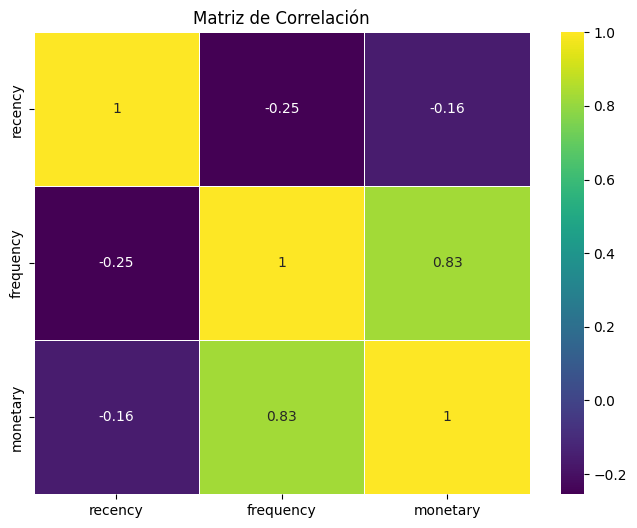

In [ ]:
corr = dataset[['recency', 'frequency', 'monetary']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

#Gráficas de Histogramas

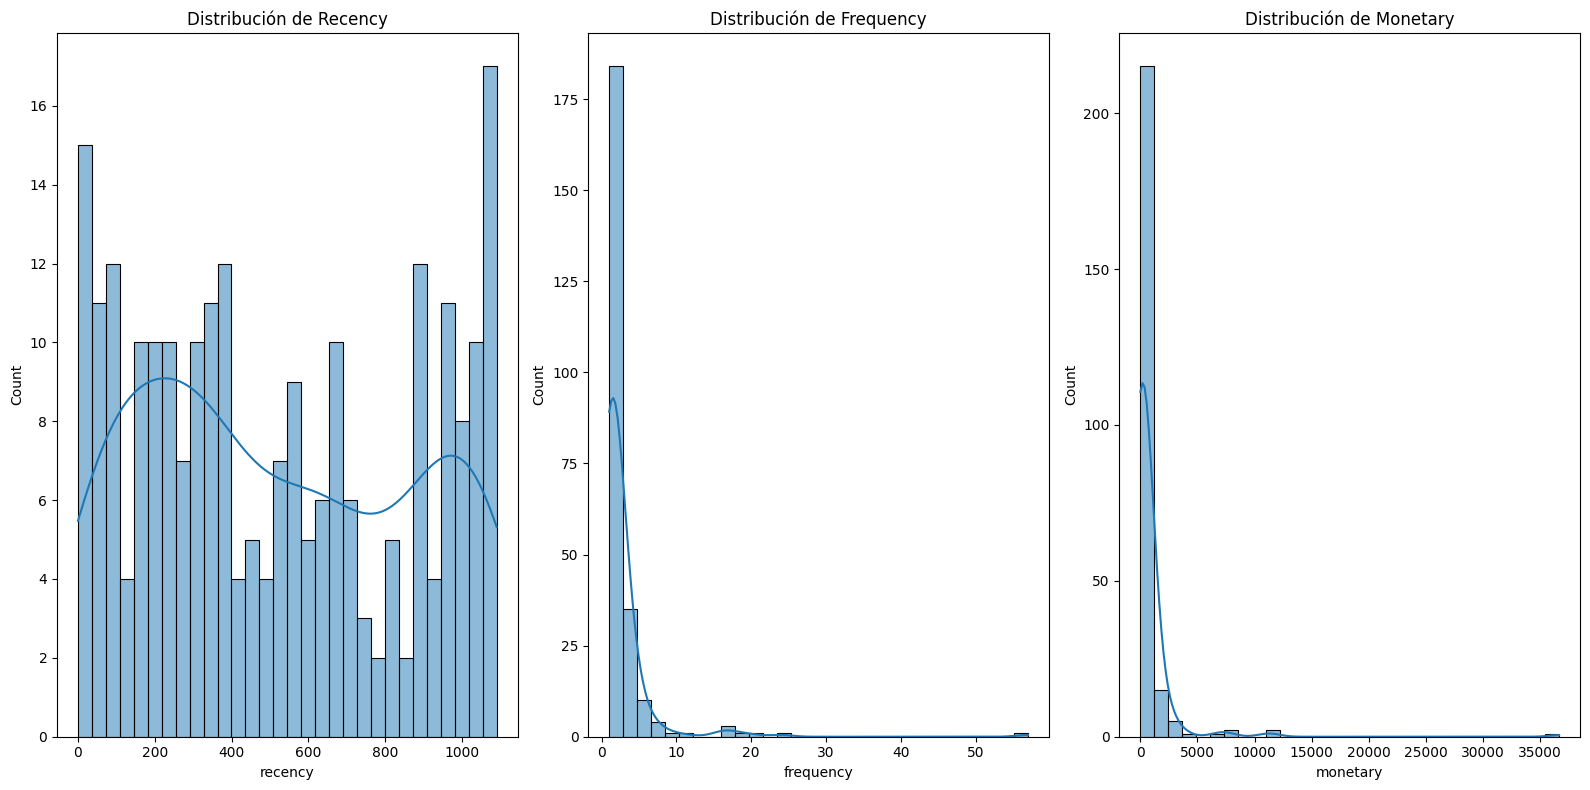

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))

sns.histplot(dataset['recency'], bins=30, ax=axes[0], kde=True)
axes[0].set_title('Distribución de Recency')

sns.histplot(dataset['frequency'], bins=30, ax=axes[1], kde=True)
axes[1].set_title('Distribución de Frequency')

sns.histplot(dataset['monetary'], bins=30, ax=axes[2], kde=True)
axes[2].set_title('Distribución de Monetary')

plt.tight_layout()
plt.show()

#Eliminación de Outliers usando Winsorización

In [ ]:
columns = ['recency', 'frequency', 'monetary']
df = dataset[columns]

from scipy.stats.mstats import winsorize

# Aplicar winsorización a todas las columnas numéricas
df_winsorized = df.copy()
for col in df_winsorized.select_dtypes(include='number').columns:
    # Winsorización al 2.5% en la cola derecha
    df_winsorized[col] = winsorize(df[col], limits=[0, 0.025])

df_winsorized.shape

(242, 3)

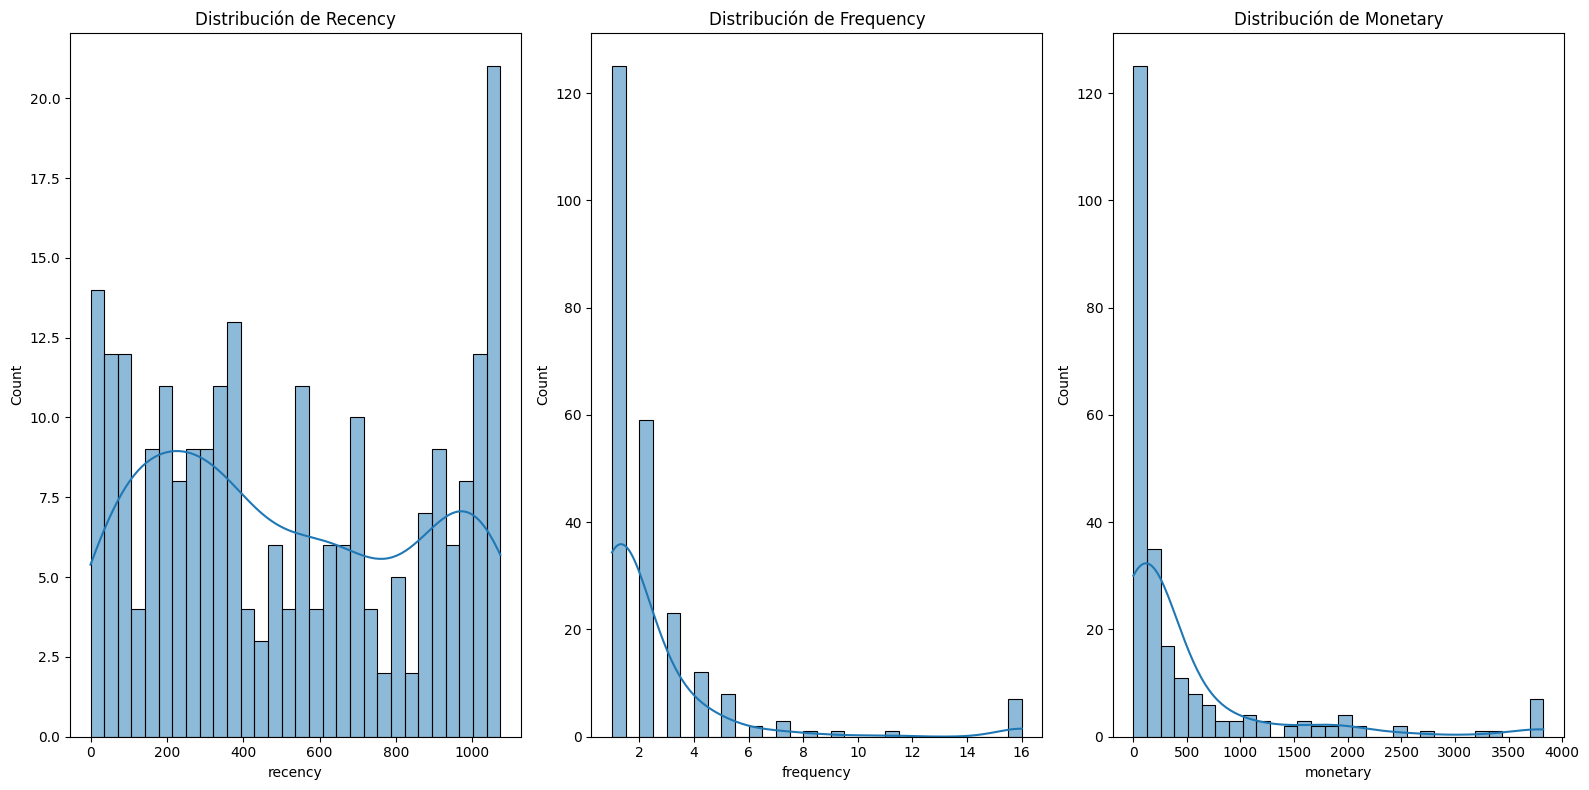

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))

sns.histplot(df_winsorized['recency'], bins=30, ax=axes[0], kde=True)
axes[0].set_title('Distribución de Recency')

sns.histplot(df_winsorized['frequency'], bins=30, ax=axes[1], kde=True)
axes[1].set_title('Distribución de Frequency')

sns.histplot(df_winsorized['monetary'], bins=30, ax=axes[2], kde=True)
axes[2].set_title('Distribución de Monetary')

plt.tight_layout()
plt.show()

#Reescalado de datos mediante StandradScaler

In [ ]:
scaler = StandardScaler()
df = scaler.fit_transform(df_winsorized)
df = pd.DataFrame(df, columns=columns)
df.head()

,recency,frequency,monetary
0,-0.429713,-0.490694,-0.463904
1,0.872613,-0.490694,-0.439666
2,1.542463,-0.490694,-0.547402
3,1.536713,-0.490694,-0.524498
4,1.470590,-0.490694,-0.535890


#Cálculo de Clústers (K) para K-Means

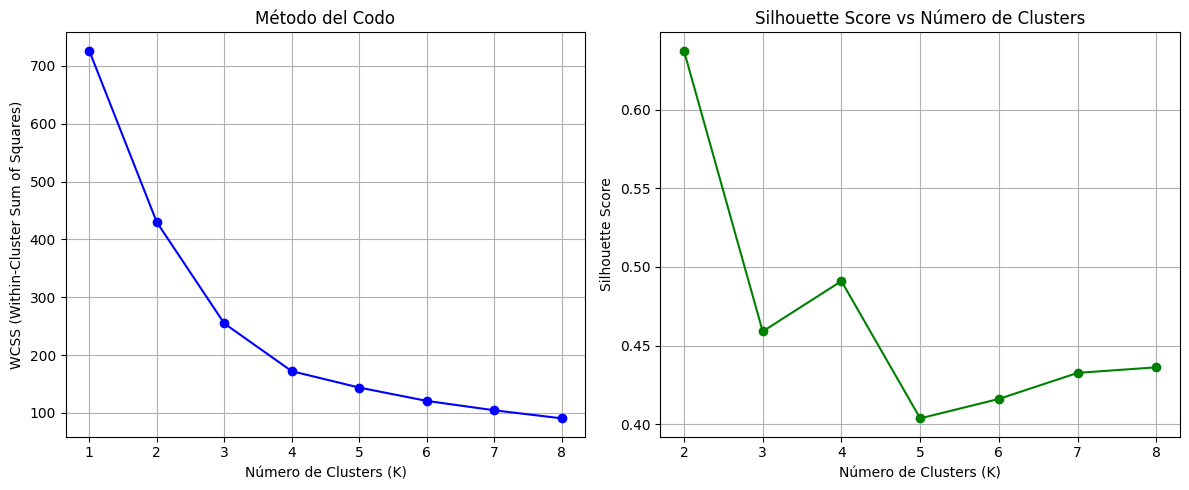

In [ ]:
# Método del Codo
wcss = []  # Lista para almacenar los WCSS para cada K

# Prueba de diferentes valores de K (1 a 8)
for k in range(1, 9):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df)  # Ajuste del modelo
    wcss.append(kmeans.inertia_)  # Obtener el WCSS

# Silhouette Score
silhouette_scores = []

# Rango de valores de K de 2 a 8
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df)
    score = silhouette_score(df, kmeans.labels_)
    silhouette_scores.append(score)

# Crear subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Gráfico 1: Método del Codo
axes[0].plot(range(1, 9), wcss, marker='o', color='b')
axes[0].set_title('Método del Codo')
axes[0].set_xlabel('Número de Clusters (K)')
axes[0].set_ylabel('WCSS (Within-Cluster Sum of Squares)')
axes[0].grid(True)

# Gráfico 2: Silhouette Score
axes[1].plot(range(2, 9), silhouette_scores, marker='o', color='g')
axes[1].set_title('Silhouette Score vs Número de Clusters')
axes[1].set_xlabel('Número de Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True)

plt.tight_layout()
plt.show()


#Modelado de K-Means


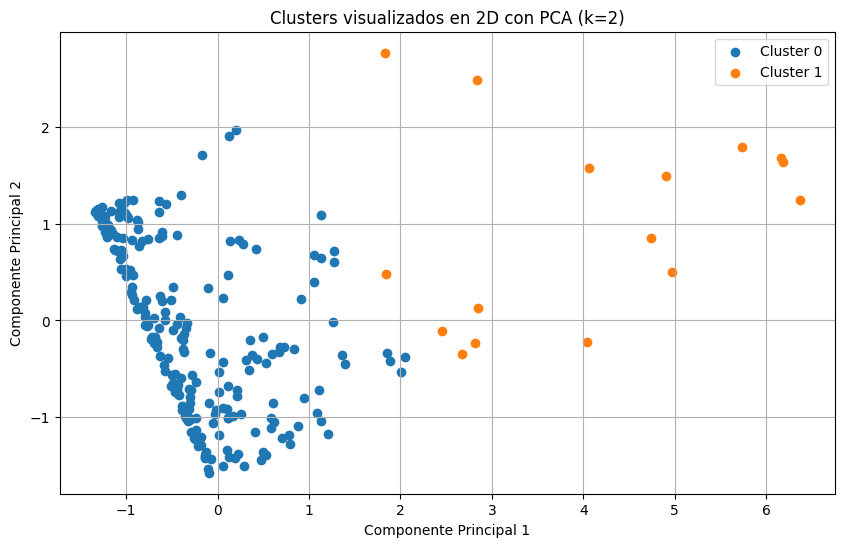

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(df)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)

# Creación de un nuevo DataFrame con resultados
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['cluster'] = clusters

# Gráfico de clústeres en 2D
plt.figure(figsize=(10, 6))
for c in df_pca['cluster'].unique():
    plt.scatter(
        df_pca[df_pca['cluster'] == c]['PC1'],
        df_pca[df_pca['cluster'] == c]['PC2'],
        label=f'Cluster {c}'
    )

plt.title('Clusters visualizados en 2D con PCA (k=2)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()

#Cálculo de Clústeres (k) para Clustering Jerárquico

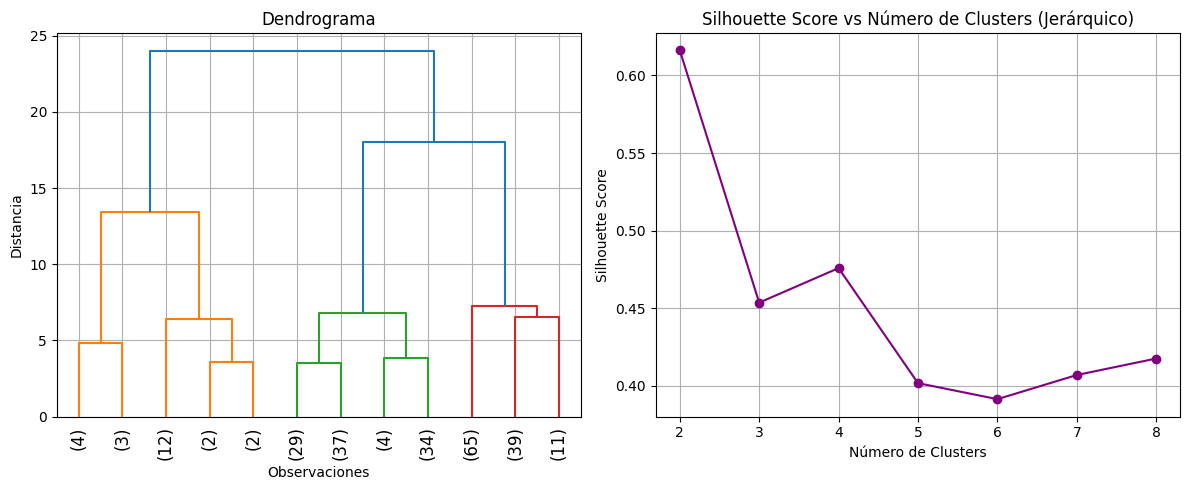

In [ ]:
# Dendrograma
linked = linkage(df, method='ward')

# Silhouette Scores para Clustering Jerárquico (K de 2 a 8)
silhouette_scores = []
cluster_range = range(2, 9)

for k in cluster_range:
    labels = fcluster(linked, t=k, criterion='maxclust')
    score = silhouette_score(df, labels)
    silhouette_scores.append(score)

# Creación de subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Gráfico 1: Dendrograma
dendrogram(linked, truncate_mode='lastp', p=12, leaf_rotation=90., ax=axes[0])
axes[0].set_title('Dendrograma')
axes[0].set_xlabel('Observaciones')
axes[0].set_ylabel('Distancia')
axes[0].grid(True)

# Gráfico 2: Silhouette Score
axes[1].plot(cluster_range, silhouette_scores, marker='o', color='purple')
axes[1].set_title('Silhouette Score vs Número de Clusters (Jerárquico)')
axes[1].set_xlabel('Número de Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True)

plt.tight_layout()
plt.show()

#Modelado de Clustering Jerárquico

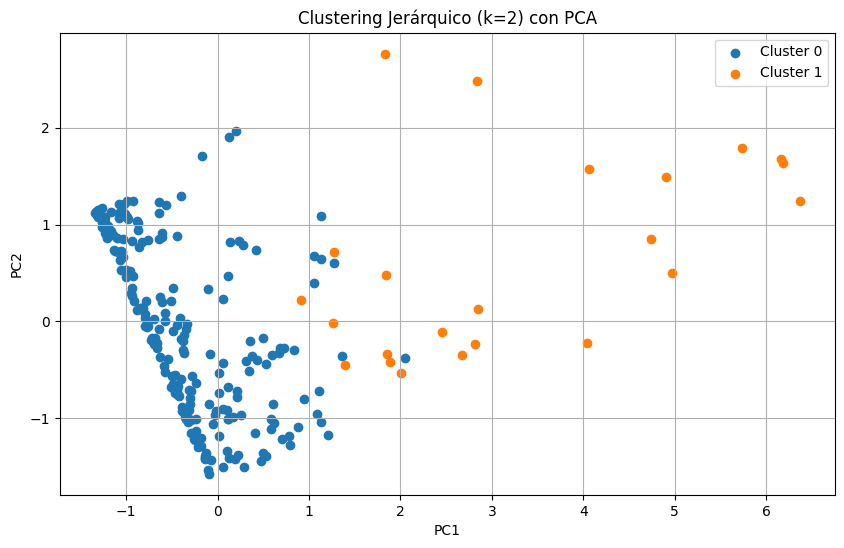

In [ ]:
# Clustering jerárquico con 2 clústeres
agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
clusters_agg = agg.fit_predict(df)

# Reducción de dimensionalidad con PCA y creación de nuevo Dataframe con resultados
pca_agg = PCA(n_components=2).fit_transform(df)
df_agg = pd.DataFrame(pca_agg, columns=["PC1", "PC2"])
df_agg["cluster"] = clusters_agg

# Gráfico de clústeres en 2D
plt.figure(figsize=(10, 6))
for c in df_agg['cluster'].unique():
    plt.scatter(
        df_agg[df_agg['cluster'] == c]["PC1"],
        df_agg[df_agg['cluster'] == c]["PC2"],
        label=f'Cluster {c}'
    )
plt.title("Clustering Jerárquico (k=2) con PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

#Cálculo de Clústeres (K) para K-Medoids

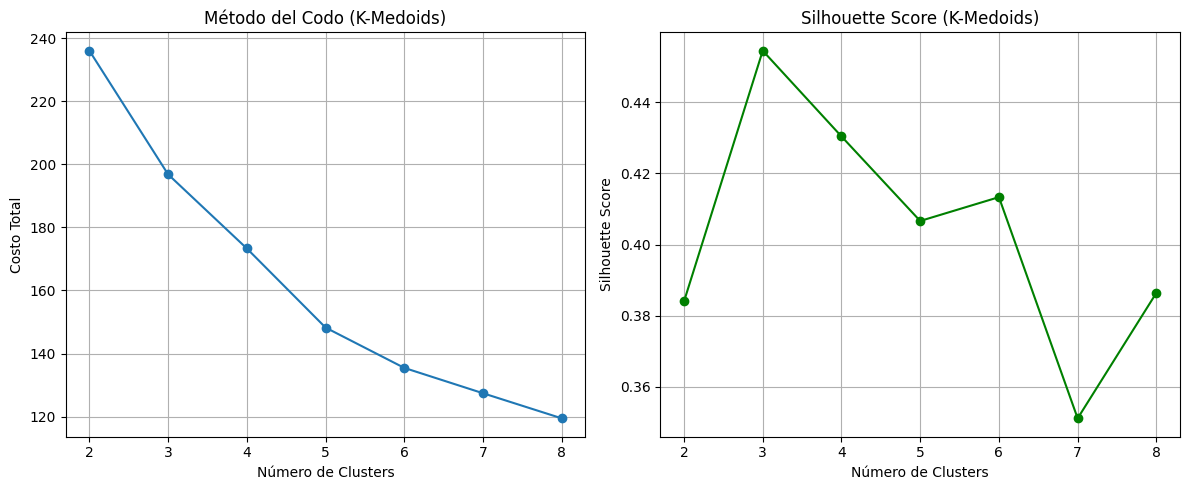

In [ ]:
# Función para realizar el cálculo del costo total manualmente
def calcular_costo_total(distance_matrix, labels, medoids):
    costo_total = 0.0
    for idx, label in enumerate(labels):
        medoid_idx = medoids[label]
        costo_total += distance_matrix[idx, medoid_idx]
    return costo_total

# Cálculo de la matriz de distancias
distance_matrix = pairwise_distances(df.values, metric='euclidean')

# Inicialización de listas para guardar resultados (Rango de K de 2 a 8)
costs = []
silhouette_scores = []
K = range(2, 9)

# Aplicación de K-Medoids usando fasterpam
for k in K:
    result = fasterpam(distance_matrix, k)

    # Cálculo de costo total manualmente
    costo_total = calcular_costo_total(distance_matrix, result.labels, result.medoids)
    costs.append(costo_total)

    # Cálculo de Silhouette Score
    silhouette_scores.append(silhouette_score(df.values, result.labels))

# Gráfico 1: Método del Codo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, costs, marker='o')
plt.title("Método del Codo (K-Medoids)")
plt.xlabel("Número de Clusters")
plt.ylabel("Costo Total")
plt.grid(True)

# Gráfico 2: Silhouette Score

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score (K-Medoids)")
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()

#Modelado de K-Medoids

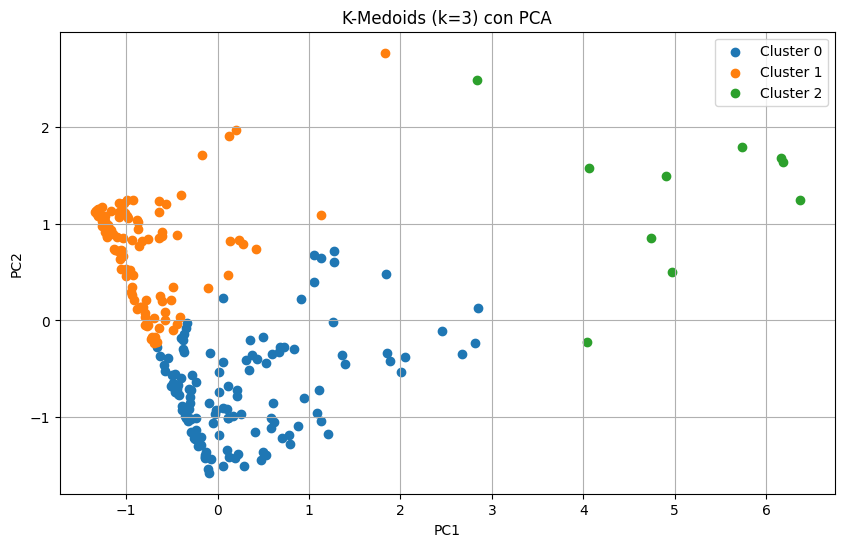

In [ ]:
# Converción a matriz de distancias
distance_matrix = pairwise_distances(df.values, metric='euclidean')

# Entrenamiento de K-Medoids con matriz de distancias
kmedoids_instance = KMedoids(n_clusters=3, random_state=42, metric='precomputed')
clusters_kmedoids = kmedoids_instance.fit_predict(distance_matrix)

# PCA para visualización
pca_kmedoids = PCA(n_components=2).fit_transform(df)
df_kmedoids = pd.DataFrame(pca_kmedoids, columns=["PC1", "PC2"])
df_kmedoids["cluster"] = clusters_kmedoids

# Gráfico de clústeres en 2D
plt.figure(figsize=(10, 6))
for c in df_kmedoids["cluster"].unique():
    plt.scatter(
        df_kmedoids[df_kmedoids["cluster"] == c]["PC1"],
        df_kmedoids[df_kmedoids["cluster"] == c]["PC2"],
        label=f"Cluster {c}"
    )
plt.title("K-Medoids (k=3) con PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

#Cálculo de Cantidad de Clientes por Clúster (K-Medoids)

In [ ]:
# Agregado del clúster al dataset reescalado
df["cluster"] = clusters_kmedoids

# Conteo de clientes en cada cluster
conteo_por_cluster = df["cluster"].value_counts().sort_index()
print(conteo_por_cluster)

cluster
0    126
1    106
2     10
Name: count, dtype: int64


#Unión del DataFrame con la columna 'id_Cliente'

In [ ]:
df['id_Cliente'] = dfCliente.values
df.head()

,recency,frequency,monetary,cluster,id_Cliente
0,-0.429713,-0.490694,-0.463904,0,5
1,0.872613,-0.490694,-0.439666,1,8
2,1.542463,-0.490694,-0.547402,1,113
3,1.536713,-0.490694,-0.524498,1,229
4,1.470590,-0.490694,-0.535890,1,163


#Descarga del DataFrame con los clientes segmentados por clústeres

In [ ]:
df.to_csv('winsorizacion.csv', index=False)
# Descarga del csv
files.download('winsorizacion.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>